In [1]:
import os

In [2]:
%pwd

'/home2/cslab/Music/Mtech-projects/Deploying-Customer-Churn-model/notebook'

In [3]:
os.chdir('../')


In [4]:
%pwd

'/home2/cslab/Music/Mtech-projects/Deploying-Customer-Churn-model'

In [5]:
os.environ["MLFLOW_TRACKING_URI"]="https://dagshub.com/shreyojitdas95/Deploying-Customer-Churn-model.mlflow"
os.environ["MLFLOW_TRACKING_USERNAME"]="shreyojitdas95"
os.environ["MLFLOW_TRACKING_PASSWORD"]="fb3a60a3faa56d9eb7c8096b032eebd944e4dd16"

In [6]:
from dataclasses import dataclass
from pathlib import Path


@dataclass(frozen=True)
class ModelEvaluationConfig:
    root_dir: Path
    test_data_path: Path
    model_path: Path
    all_params: dict
    metric_file_name: Path
    target_column: str
    mlflow_uri: str
    confusion_matrix_file: str
    roc_curve_file: str

In [7]:
from mlFlowProject.constants import *
from mlFlowProject.utils.common import read_yaml, create_directories, save_json

In [8]:
class ConfigurationManager:
    def __init__(
        self,
        config_filepath = CONFIG_FILE_PATH,
        params_filepath = PARAMS_FILE_PATH,
        schema_filepath = SCHEMA_FILE_PATH):

        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
        self.schema = read_yaml(schema_filepath)

        create_directories([self.config.artifacts_root])

    def get_model_evaluation_config(self) -> ModelEvaluationConfig:
        config = self.config.model_evaluation
        params = self.params.LightGBM
        schema =  self.schema.TARGET_COLUMN

        create_directories([config.root_dir])

        model_evaluation_config = ModelEvaluationConfig(
            root_dir = config.root_dir,
            test_data_path = config.test_data_path,
            model_path = config.model_path,
            all_params = params,
            confusion_matrix_file = config.confusion_matrix_file,  # Added missing comma here
            metric_file_name = config.metric_file_name,
            roc_curve_file = config.roc_curve_file,
            target_column = schema.name,
            mlflow_uri="https://dagshub.com/shreyojitdas95/Deploying-Customer-Churn-model.mlflow",  
        )

        return model_evaluation_config


In [9]:
import os
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import mlflow
import mlflow.sklearn
import joblib
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
from urllib.parse import urlparse

In [10]:
import mlflow
import joblib
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from urllib.parse import urlparse
from dataclasses import dataclass
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    confusion_matrix, roc_curve, auc
)


class ModelEvaluation:
    def __init__(self, config: ModelEvaluationConfig):
        self.config = config

    def eval_metrics(self, actual, pred):
        accuracy = accuracy_score(actual, pred)
        precision = precision_score(actual, pred)
        recall = recall_score(actual, pred)
        f1 = f1_score(actual, pred)

        return accuracy, precision, recall, f1

    def save_json(self, path: Path, data: dict):
        """Saves a dictionary as a JSON file."""
        # Ensure path is a Path object, not a string
        path = Path(path)
        path.write_text(json.dumps(data, indent=4))
   

    def log_into_mlflow(self):
        test_data = pd.read_csv(self.config.test_data_path)
        model = joblib.load(self.config.model_path)

        test_x = test_data.drop([self.config.target_column], axis=1)
        test_y = test_data[[self.config.target_column]]

        mlflow.set_registry_uri(self.config.mlflow_uri)
        tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

        with mlflow.start_run():
            # Log tags
            mlflow.set_tag("model_version", "v1.0")
            mlflow.set_tag("experiment_name", "Model Evaluation Experiment")
            mlflow.set_tag("target_column", self.config.target_column)
            mlflow.set_tag("data_source", str(self.config.test_data_path))
            mlflow.set_tag("evaluation_time", str(datetime.datetime.now()))

            predictions = model.predict(test_x)
            accuracy, precision, recall, f1 = self.eval_metrics(test_y, predictions)

            # Saving metrics locally
            scores = {
                "accuracy": accuracy,
                "precision": precision,
                "recall": recall,
                "f1": f1
            }
            self.save_json(path=self.config.metric_file_name, data=scores)

            # Log metrics to MLflow
            mlflow.log_params(self.config.all_params)
            mlflow.log_metric("accuracy", accuracy)
            mlflow.log_metric("precision", precision)
            mlflow.log_metric("recall", recall)
            mlflow.log_metric("f1-score", f1)

            # Log confusion matrix as artifact
            cm = confusion_matrix(test_y, predictions)
            cm_file = "confusion_matrix.png"
            plt.figure(figsize=(8, 6))
            sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                        xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
            plt.title("Confusion Matrix")
            plt.savefig(cm_file)
            mlflow.log_artifact(cm_file)  # Log it to MLflow
            self.save_json(path=self.config.confusion_matrix_file, data=cm.tolist())  # Optionally save locally

            # Log ROC curve as artifact
            fpr, tpr, _ = roc_curve(test_y, model.predict_proba(test_x)[:, 1])
            roc_auc = auc(fpr, tpr)
            roc_file = "roc_curve.png"
            plt.figure()
            plt.plot(fpr, tpr, color="blue", lw=2, label="ROC curve (area = %0.2f)" % roc_auc)
            plt.plot([0, 1], [0, 1], color="gray", lw=2, linestyle="--")
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title("Receiver Operating Characteristic")
            plt.legend(loc="lower right")
            plt.savefig(roc_file)
            mlflow.log_artifact(roc_file)  # Log it to MLflow
            self.save_json(path=self.config.roc_curve_file, data={"fpr": fpr.tolist(), "tpr": tpr.tolist()})  # Optionally save locally

            # Log the model into MLflow
            if tracking_url_type_store != "file":
                mlflow.sklearn.log_model(model, "model", registered_model_name="LightGBM")
            else:
                mlflow.sklearn.log_model(model, "model")


[2025-02-06 13:44:26,822: INFO: common: yaml file: config/config.yaml loaded successfully]
[2025-02-06 13:44:26,823: INFO: common: yaml file: params.yaml loaded successfully]
[2025-02-06 13:44:26,825: INFO: common: yaml file: schema.yaml loaded successfully]
[2025-02-06 13:44:26,825: INFO: common: created directory at: artifacts]
[2025-02-06 13:44:26,826: INFO: common: created directory at: artifacts/model_evaluation]


2025/02/06 13:44:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'LightGBM'.
2025/02/06 13:44:40 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LightGBM, version 1
Created version '1' of model 'LightGBM'.


🏃 View run upbeat-sheep-314 at: https://dagshub.com/shreyojitdas95/Deploying-Customer-Churn-model.mlflow/#/experiments/0/runs/093beca549744f90987be216fa87d265
🧪 View experiment at: https://dagshub.com/shreyojitdas95/Deploying-Customer-Churn-model.mlflow/#/experiments/0


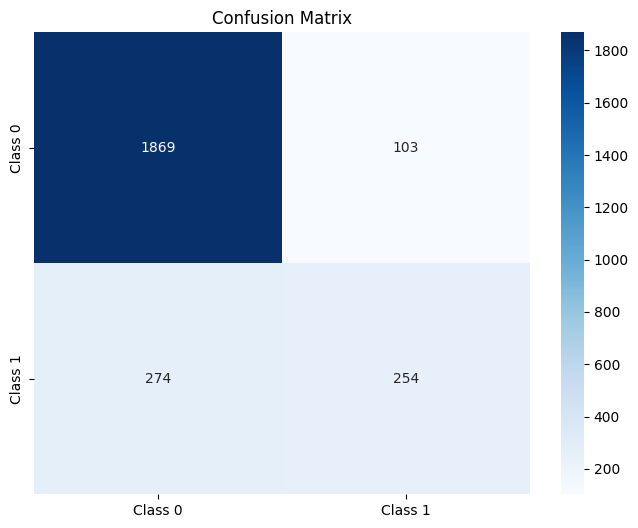

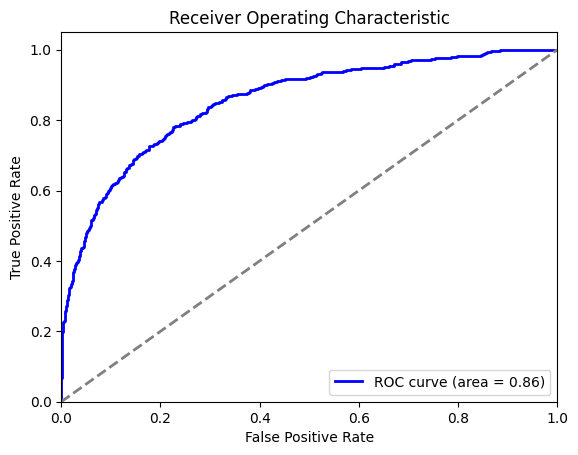

In [11]:
try:
    config = ConfigurationManager()
    model_evaluation_config = config.get_model_evaluation_config()
    model_evaluation_config = ModelEvaluation(config=model_evaluation_config)
    model_evaluation_config.log_into_mlflow()
except Exception as e:
    raise e